In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
# imports
import torch
import matplotlib.pyplot as plt
import numpy as np
import sys
from scipy.integrate import solve_ivp

# Add parent directory to sys.path
from pathlib import Path
current_path = Path.cwd()
parent_dir = current_path.parent.parent
sys.path.append(str(parent_dir))

# Import necessary modules
from src.utils_plot import plot_loss_and_all_solution
from src.load_save import load_run_history
from src.transfer_learning import compute_H_and_dH_dt, analytically_compute_weights

from src.utils_plot import plot_transfer_learned_and_analytical

torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

In [3]:
def check_versions_and_device():
  # set the device to the GPU if it is available, otherwise use the CPU
  current_dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  !nvidia-smi
  return current_dev

# set a global device variable to use in code
dev = check_versions_and_device()
print(dev)

Tue Feb 27 11:53:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.13                 Driver Version: 537.13       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   39C    P8              N/A / ERR! |      0MiB /  2048MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

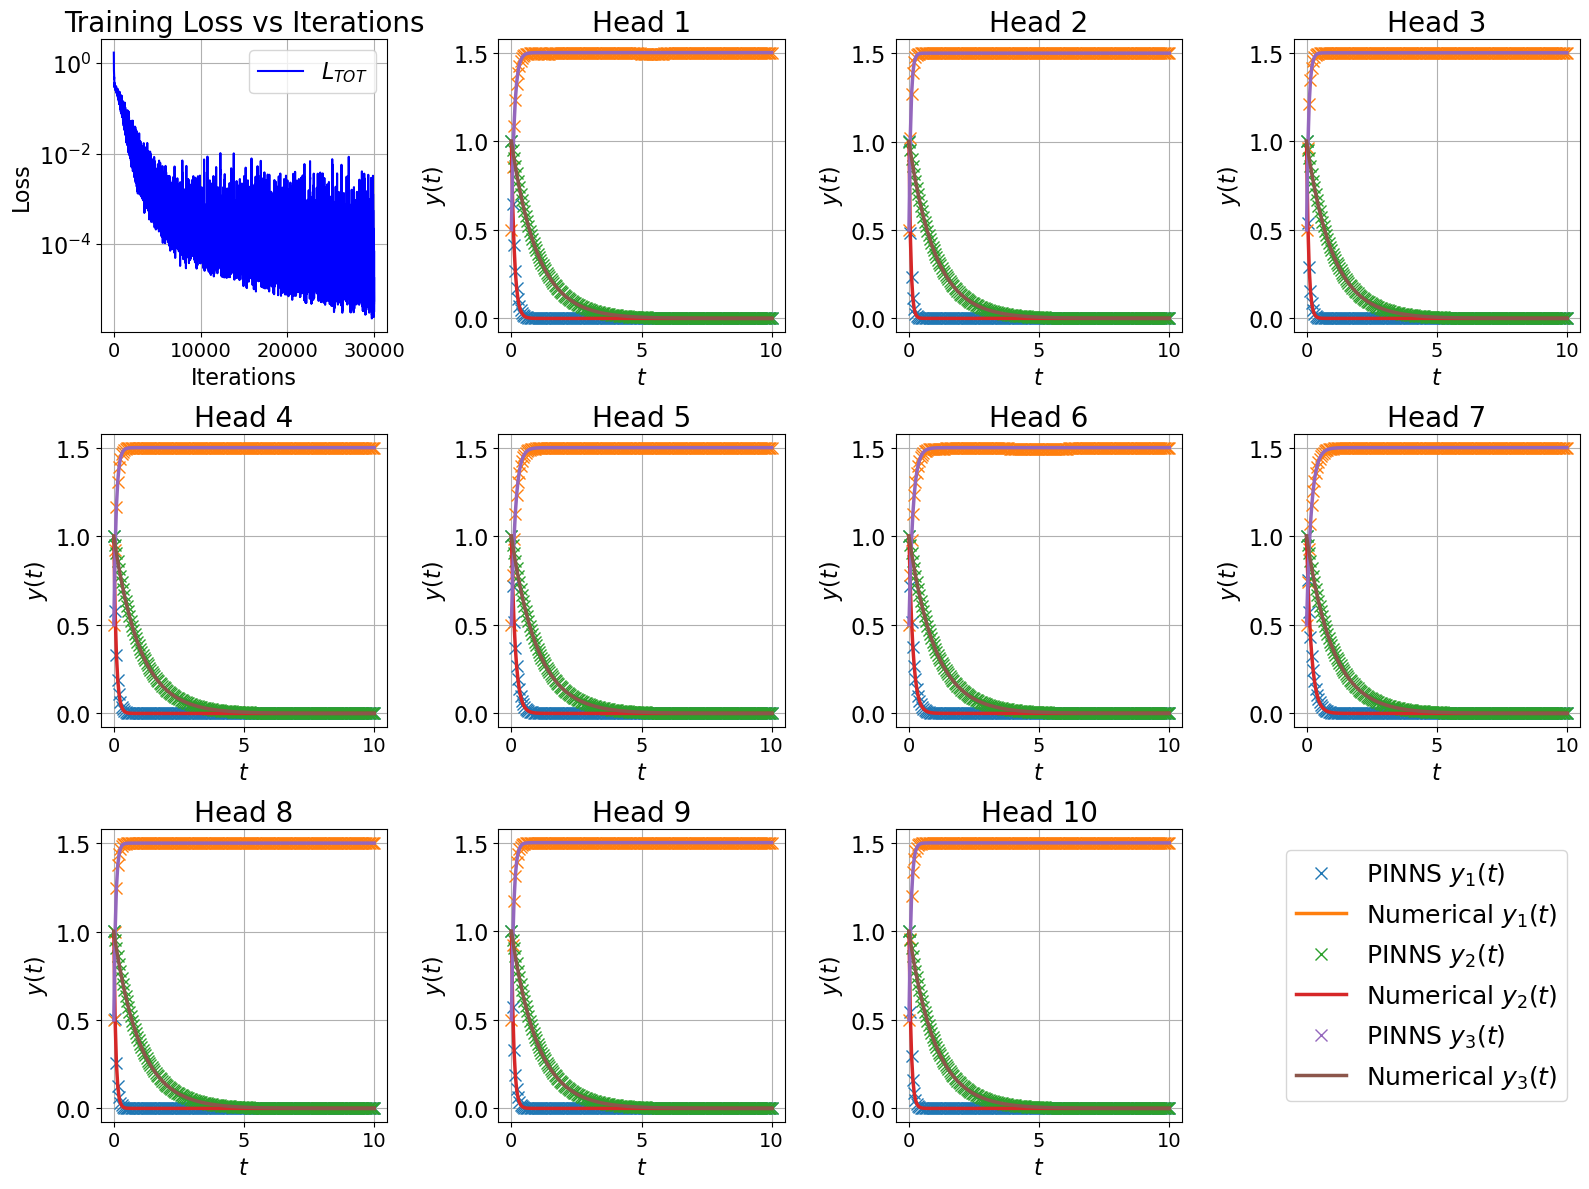

In [4]:
file_name = "linear_new_2231916"
equation_name = "catalysis"

trained_model, \
x_range, \
iterations, \
hid_lay, \
num_equations, \
num_heads, \
loss_hist, \
alpha_list, \
A_list, \
IC_list, \
force_list = load_run_history(equation_name, file_name, dev, prev=False)

# function to numerically compute the solution to any set of two coupled, linear first-order ODES
def triple_coupled_equation(t, y, A, force):
    return np.array([force[0].detach().item() - A[0][2] * y[2] - A[0][1] * y[1] - A[0][0] * y[0] ,
                     force[1].detach().item() - A[1][2] * y[2] - A[1][1] * y[1] - A[1][0] * y[0] , 
                     force[2].detach().item() - A[2][2] * y[2] - A[2][1] * y[1] - A[2][0] * y[0]])

numerical_sol_fct = lambda x, v, A, force: (solve_ivp(triple_coupled_equation, [x_range[0], x_range[1]],
                                                    v.squeeze(), args=(A, force), t_eval=x.squeeze(), method="Radau").y)

# create the A matrix associated with the ODE
def get_A(alpha):
    return torch.tensor([[alpha, 0., 0.], [-alpha, 0., 0.], [0., 0., 1.]], device=dev).double() 

plot_loss_and_all_solution(x_range=x_range, true_functs=numerical_sol_fct,
                           trained_model=trained_model, v_list=IC_list, A_list=A_list,
                           force=force_list, train_losses=loss_hist, device=dev)

## One-Shot Transfer Learning

In [7]:
# forward pass to extract H, H0 and dH/dt
size = 512
H, H_0, dH_dt_new, t_eval = compute_H_and_dH_dt(x_range[0], x_range[1], trained_model, num_equations, hid_lay, size, dev)
H = H.double()
H_0 = H_0.double()
dH_dt_new = dH_dt_new.double()
t_eval = t_eval.double()

Time to compute H and dH_dt:  4.232 seconds


Time to compute weights (given H and dH_dt):  0.650 seconds
mean 6.365428946022831e-05
max 0.0011812769017670033
mean 0.0028060588207412156
max 0.008677711409894151
mean 0.0010471436312092552
max 0.002301594448471047


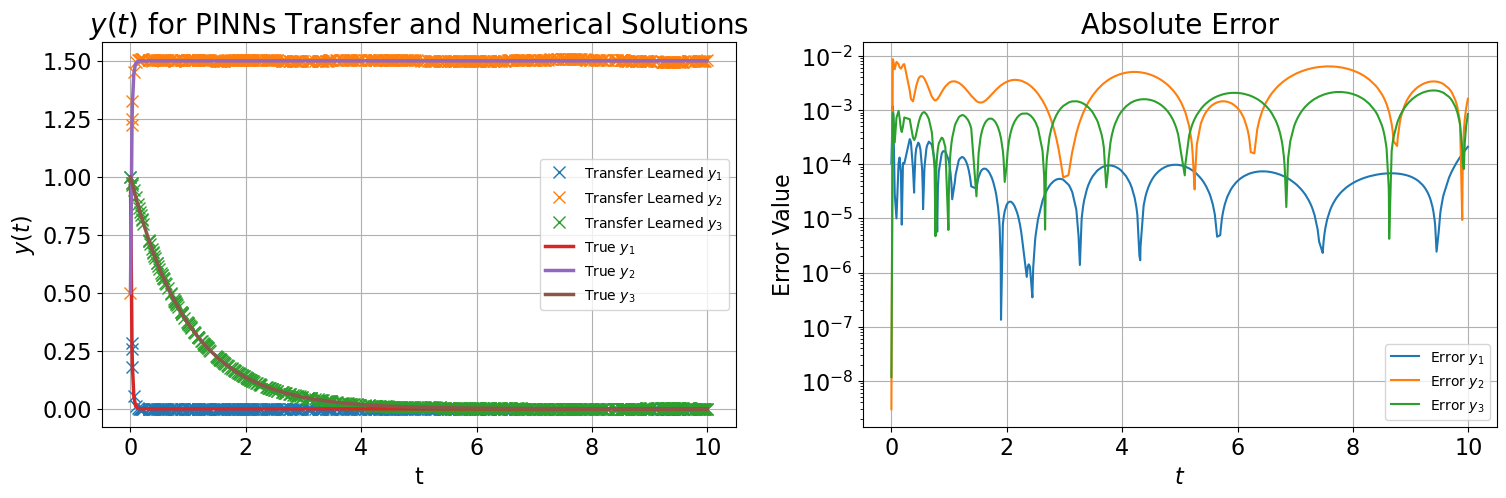

In [15]:
# Transfer on the linear system Choose alpha, IC and force to transfer on
alpha_transfer = 50
A_transfer = get_A(alpha=alpha_transfer)
IC_transfer = IC_list[2].double()
force_transfer = force_list[2].double()

M_inv, W_out, force_terms, total_time = analytically_compute_weights(dH_dt_new, H, H_0, t_eval,
                                                                     IC_transfer, A_transfer,
                                                                     force_transfer)
plot_transfer_learned_and_analytical(H, W_out, t_eval, IC_transfer, A_transfer,
                                     force_transfer, num_equations, numerical_sol_fct)

In [11]:
alpha_transfer = 50; beta = 0.01

domain = (x_range[0], x_range[1]);
A_transfer = get_A(alpha=alpha_transfer)
IC_transfer = IC_list[2].double()
force_transfer = force_list[2].double()

def numerical_non_linear_solution(alpha, beta, u0, domain, t_eval, method="Radau", r_tol= 1e-8):
  def F(t, y):
    return [ -alpha*y[0],
             alpha*y[0] - 2*beta*y[1]**2,
             -y[2] + beta*y[1]**2]
  solution = solve_ivp(F, domain, u0, t_eval=t_eval, method=method, r_tol=r_tol)
  return solution

non_linear_num_sol = numerical_non_linear_solution(alpha_transfer, beta, IC_transfer.detach().cpu().squeeze(), domain, t_eval.detach().cpu().numpy().squeeze())

d:\Logiciel\Anaconda\envs\pinns\lib\site-packages\scipy\integrate\_ivp\common.py:39: UserWarning: The following arguments have no effect for a chosen solver: `r_tol`.
  warn("The following arguments have no effect for a chosen solver: {}."


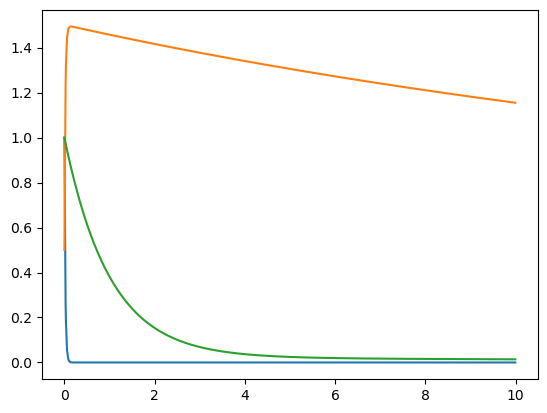

In [12]:
plt.plot(non_linear_num_sol.t, non_linear_num_sol.y[0])
plt.plot(non_linear_num_sol.t, non_linear_num_sol.y[1])
plt.plot(non_linear_num_sol.t, non_linear_num_sol.y[2])

In [13]:
from src.nonlinear_transfer_learning import solve_perturbation_TL

# functions to calculate the force function of each system p
def force_func_index(n):
    solution_index = [] # ind1, ind2, coeff
    for a in range(n+1):
        for b in range(a+1):
                if ((a+b)==n):
                    if a==b:
                        solution_index.append([a, b, 1])
                    else:
                        solution_index.append([a, b, 2])
    return solution_index

def force_function_PINNS(i, alpha, list_force_index, PINNS_list):
      result= 0
      for force_ind in list_force_index[i-1]:
        result += force_ind[2]*((PINNS_list[force_ind[0]][:, 1, :]*PINNS_list[force_ind[1]][:, 1, :]))
      return torch.hstack((torch.zeros_like(result), -2*result, result))

def force_function_numerical(i, alpha, list_force_index, numerical_pert_list):
      result= 0
      for force_ind in list_force_index[i-1]:
        result += force_ind[2]*((numerical_pert_list[force_ind[0]][1, :]*numerical_pert_list[force_ind[1]][1, :]))
      return np.vstack((np.zeros_like(result), -2*result, result)).T

def solve_numericaly_perturbation(t, y, A, force, t_eval):
    index = np.argmin(np.abs(t_eval- t))
    return np.array([force[index, 0] - A[0][2] * y[2] - A[0][1] * y[1] - A[0][0] * y[0] ,
                     force[index, 1] - A[1][2] * y[2] - A[1][1] * y[1] - A[1][0] * y[0] , 
                     force[index, 2] - A[2][2] * y[2] - A[2][1] * y[1] - A[2][0] * y[0]])


numerical_perturbation_fct = lambda x, v, A, force: (solve_ivp(solve_numericaly_perturbation, [x_range[0], x_range[1]],
                                                    v.squeeze(), args=(A, force, x), t_eval=x.squeeze(), method="Radau"))


In [14]:
p=3
compute_numerical_pert = False

solution_PINNS, \
solution_numerical, \
PINNS_list, \
numerical_pert_list, \
total_time = solve_perturbation_TL(beta=beta, p=p, t_eval=t_eval,
                                   alpha=alpha_transfer, A=A_transfer,
                                   force=force_transfer, IC=IC_transfer,
                                   H=H, H_0=H_0, dH_dt=dH_dt_new, dev=dev,
                                   force_func_index=force_func_index,
                                   numerical_sol_fct=numerical_sol_fct,
                                   force_function_PINNS=force_function_PINNS,
                                   force_function_numerical=force_function_numerical,
                                   compute_numerical_pert=compute_numerical_pert,
                                   numerical_perturbation_fct=numerical_perturbation_fct,
                                   verbose=True)

Solving the 0th linear ode system...
Time to compute inverse of M: 5.26e-01
Time to compute W0: 1.25e-01
Solving the 1th linear ode system...
Time to compute W1: 9.64e-03
Solving the 2th linear ode system...
Time to compute W2: 0.00e+00
Solving the 3th linear ode system...
Time to compute W3: 0.00e+00
4 systems solved in 6.612e-01 seconds


Text(0.5, 0.98, 'Solving non linear stiff ODE with $\\alpha=50$, $\\beta=0.01$, $p=10$')

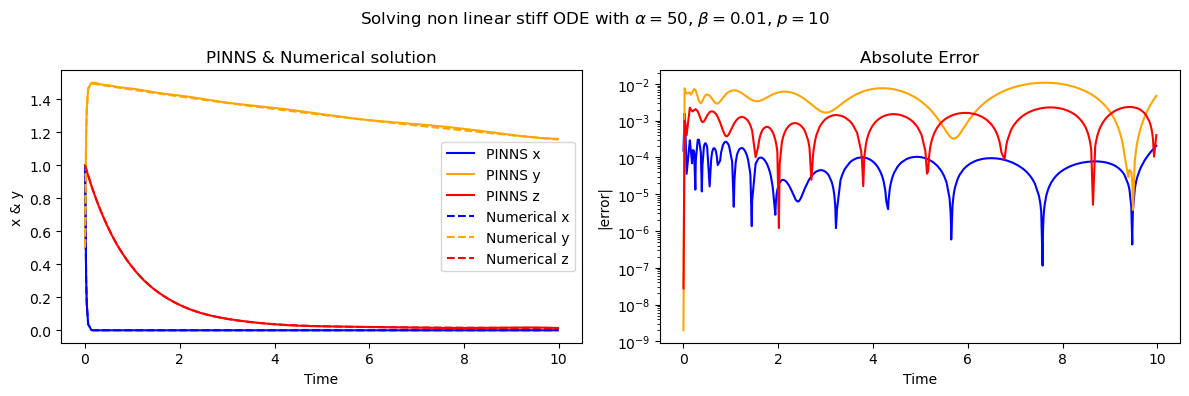

In [37]:
t_numpy = t_eval.detach().cpu().numpy().squeeze()

fig, ax = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)
# plot PINNS solution
ax[0].plot(t_numpy, solution_PINNS[:, 0], c='blue', label='PINNS x');
ax[0].plot(t_numpy, solution_PINNS[:, 1], c='orange', label='PINNS y');
ax[0].plot(t_numpy, solution_PINNS[:, 2], c='red', label='PINNS z');

# plot Numerical solution
ax[0].plot(t_numpy, non_linear_num_sol.y[0], '--', c='blue', label="Numerical x");
ax[0].plot(t_numpy, non_linear_num_sol.y[1], '--', c='orange', label="Numerical y");
ax[0].plot(t_numpy, non_linear_num_sol.y[2], '--', c='red', label='Numerical z');

# plot numerical solution by perturbation
if compute_numerical_pert:
    ax[0].plot(t_numpy[::10], solution_numerical[::10, 0], '*', c='blue', label='Numerical perturbation x', markersize=5)
    ax[0].plot(t_numpy[::10], solution_numerical[::10, 1], '*', c='orange', label='Numerical perturbation y')
    ax[0].plot(t_numpy[::10], solution_numerical[::10, 2], '*', c='red', label='Numerical perturbation y')

ax[0].set_xlabel("Time");
ax[0].set_ylabel("x & y");
ax[0].legend(loc="best");
ax[0].set_title(fr"PINNS & Numerical solution")

# plot errors
ax[1].plot(t_numpy, np.abs(solution_PINNS[:, 0]-non_linear_num_sol.y[0]), c='blue', label='error x');
ax[1].plot(t_numpy, np.abs(solution_PINNS[:, 1]-non_linear_num_sol.y[1]), c='orange', label='error y');
ax[1].plot(t_numpy, np.abs(solution_PINNS[:, 2]-non_linear_num_sol.y[2]), c='red', label='error z');
ax[1].set_yscale('log')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('|error|')
ax[1].set_title('Absolute Error')

fig.suptitle(fr"Solving non linear stiff ODE with $\alpha={alpha_transfer}$, $\beta={beta:.2f}$, $p={p}$")


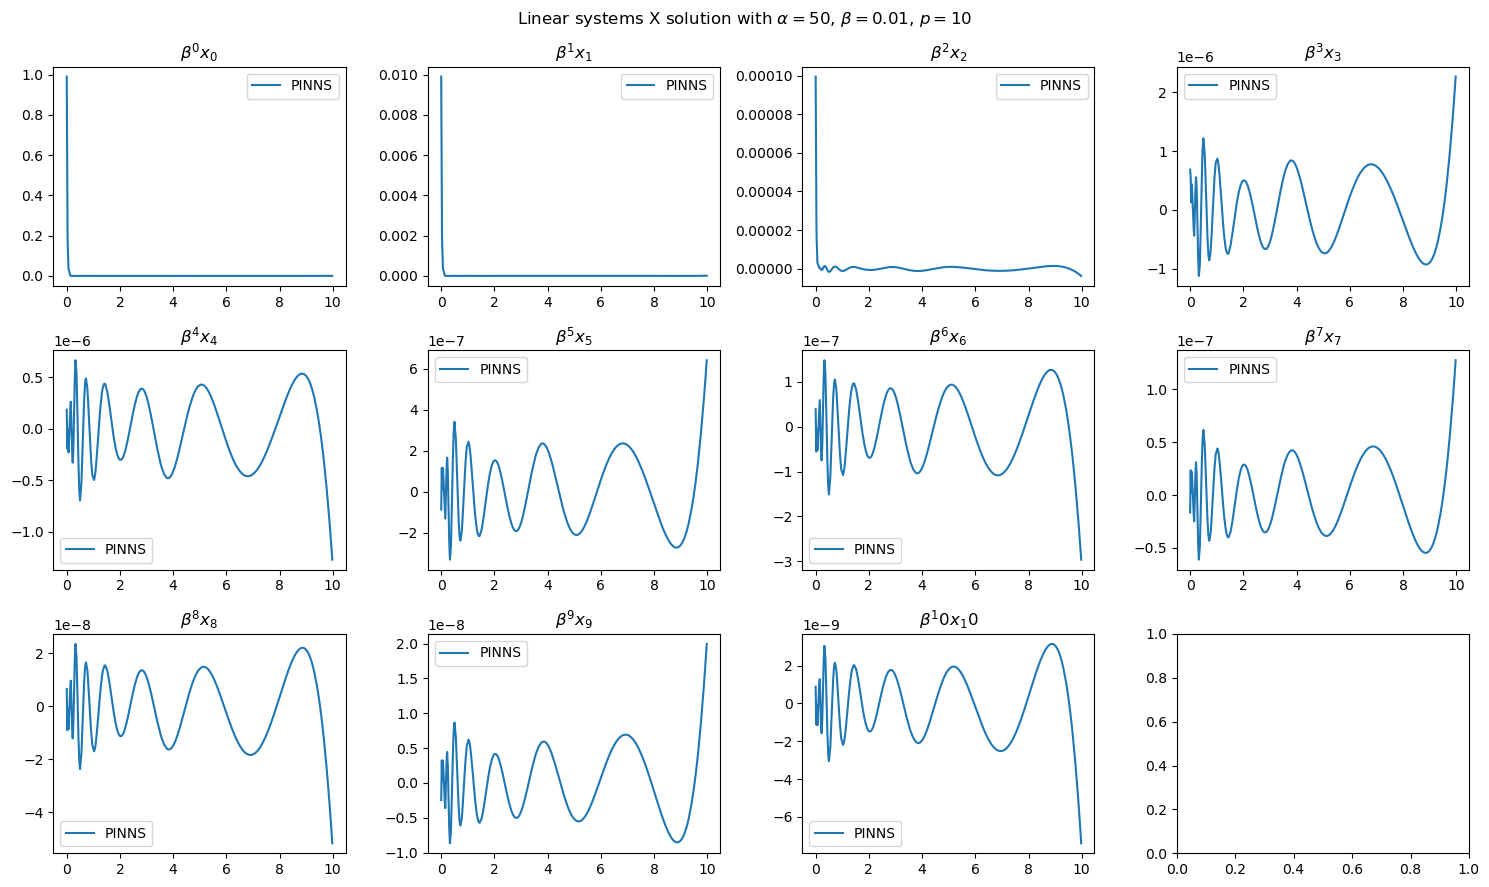

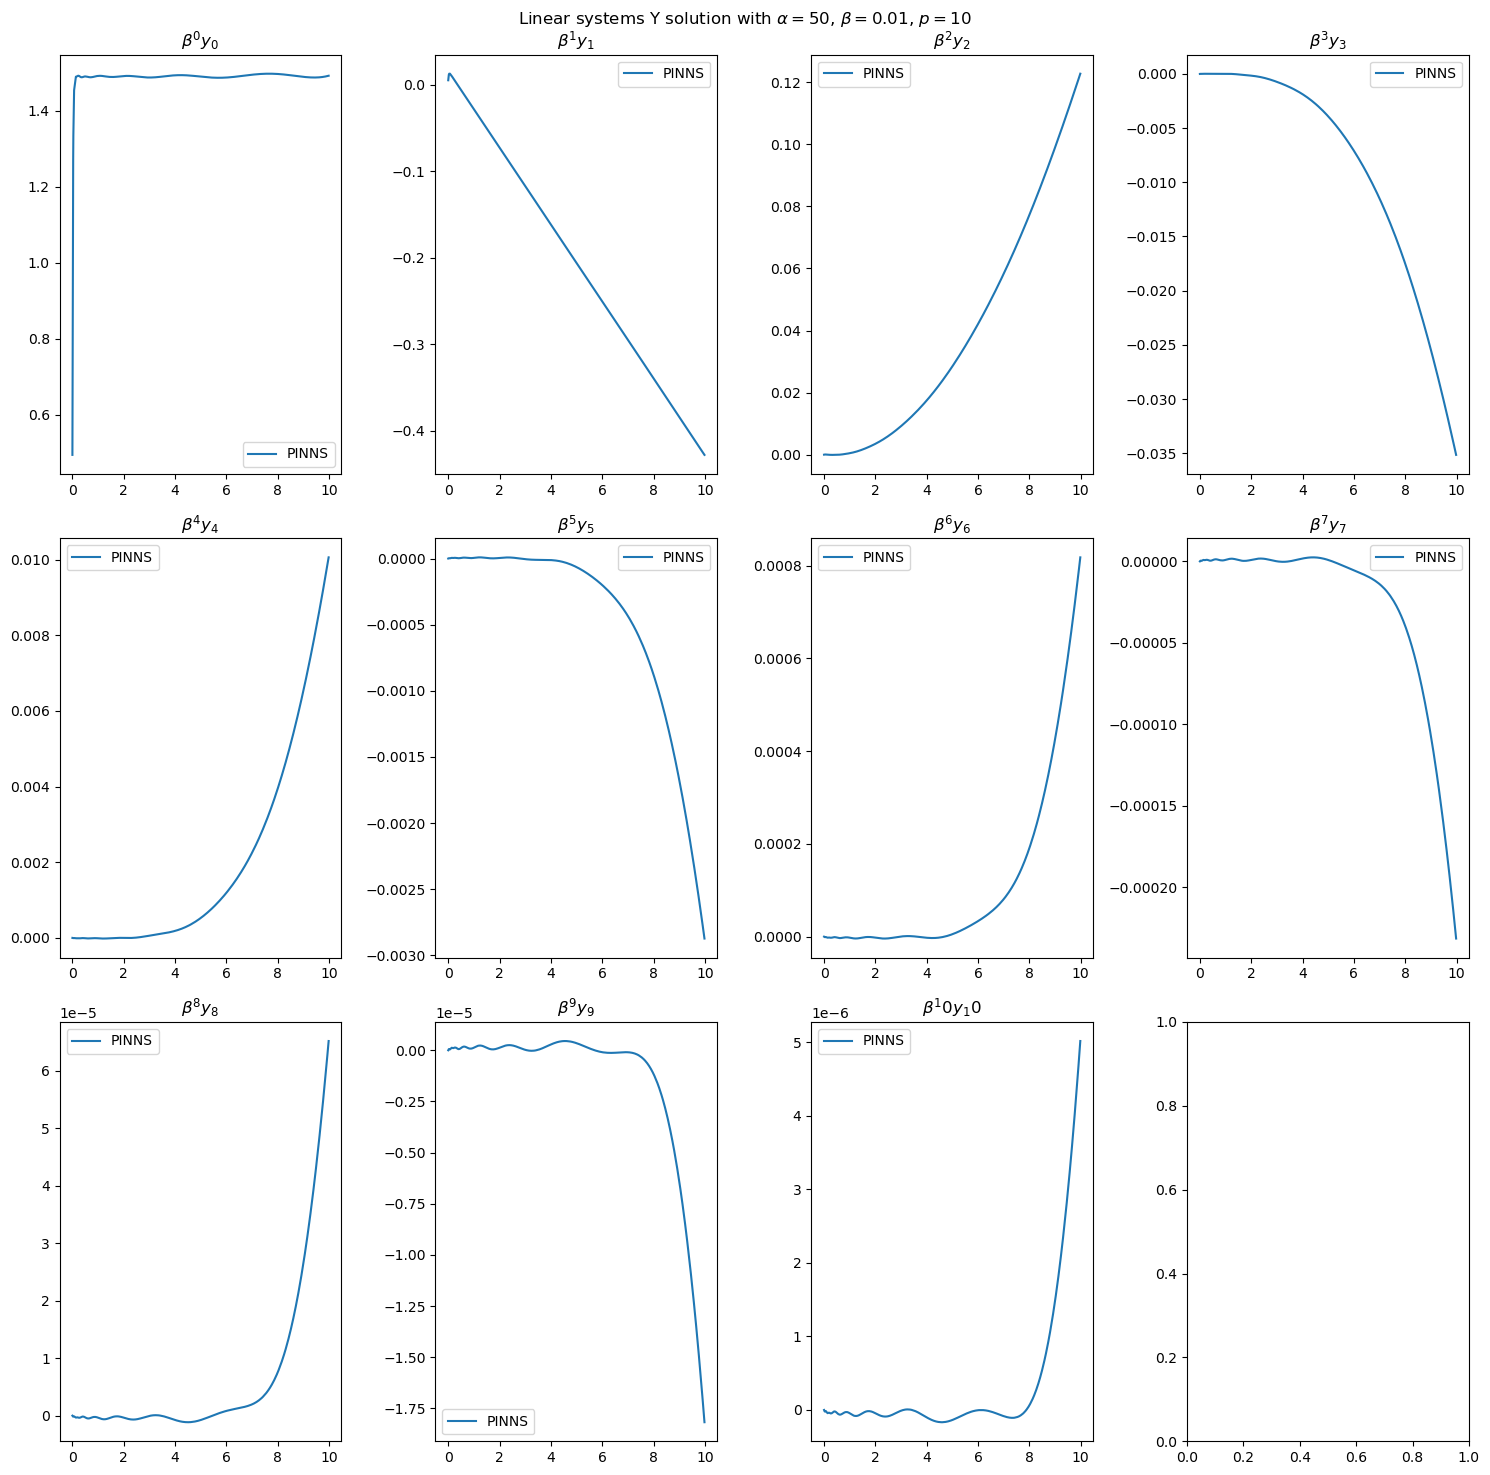

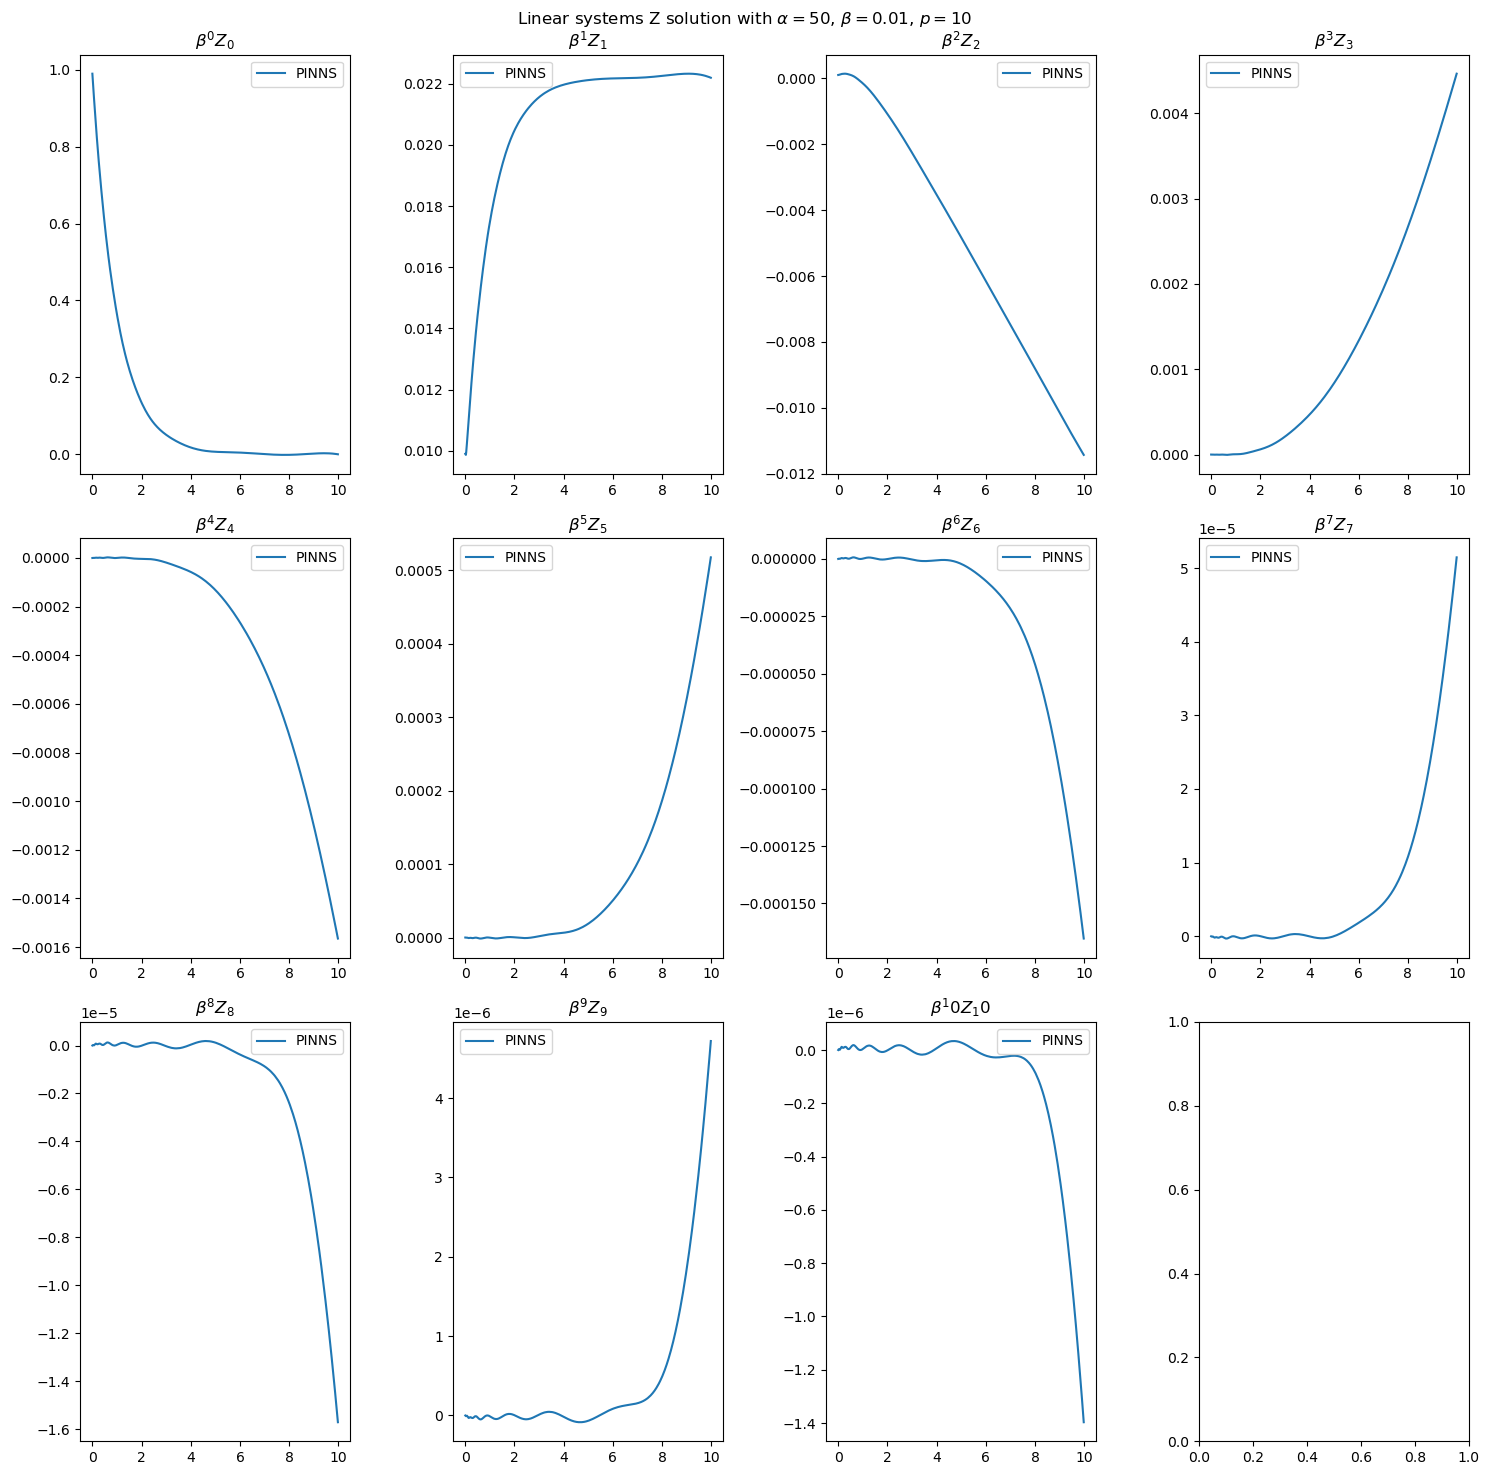

In [38]:
# plot Xi
nb_row_plot = (p+1)//4+1 if (p+1)%4!=0 else (p+1)//4
fig, ax = plt.subplots(nb_row_plot, 4, figsize=(15, nb_row_plot*3))
for i in range(p+1):
  j = i//4; k = i%4
  pert_coeff = (beta)**i
  ax[j][k].plot(t_numpy, PINNS_list[i][:, 0]*pert_coeff, label="PINNS")
  if compute_numerical_pert:
    ax[j][k].plot(t_numpy, numerical_pert_list[i][:, 0]*pert_coeff, '--', label="Numerical")
  ax[j][k].set_title(rf"$\beta^{i} x_{i}$")
  ax[j][k].legend(loc="best")
fig.suptitle(fr"Linear systems X solution with $\alpha={alpha_transfer}$, $\beta={beta:.2f}$, $p={p}$")
fig.tight_layout()

# plot Yi
fig, ax = plt.subplots(nb_row_plot, 4, figsize=(15, nb_row_plot*5))
for i in range(p+1):
  j = i//4; k = i%4
  pert_coeff = (beta)**i
  ax[j][k].plot(t_numpy, PINNS_list[i][:, 1]*pert_coeff, label="PINNS")
  if compute_numerical_pert:
    ax[j][k].plot(t_numpy, numerical_pert_list[i][:, 1]*pert_coeff, '--', label="Numerical")
  ax[j][k].set_title(rf"$\beta^{i} y_{i}$")
  ax[j][k].legend(loc="best")
fig.suptitle(fr"Linear systems Y solution with $\alpha={alpha_transfer}$, $\beta={beta:.2f}$, $p={p}$")
fig.tight_layout()


# plot Zi
fig, ax = plt.subplots(nb_row_plot, 4, figsize=(15, nb_row_plot*5))
for i in range(p+1):
  j = i//4; k = i%4
  pert_coeff = (beta)**i
  ax[j][k].plot(t_numpy, PINNS_list[i][:, 2]*pert_coeff, label="PINNS")
  if compute_numerical_pert:
    ax[j][k].plot(t_numpy, numerical_pert_list[i][:, 2]*pert_coeff, '--', label="Numerical")
  ax[j][k].set_title(rf"$\beta^{i} Z_{i}$")
  ax[j][k].legend(loc="best")
fig.suptitle(fr"Linear systems Z solution with $\alpha={alpha_transfer}$, $\beta={beta:.2f}$, $p={p}$")
fig.tight_layout()

In [32]:
#p_list = [i for i in range(0, 20, 3)]
p_list = [i for i in range(0, 10)]
compute_numerical_pert = False
sol_PINNS_list =[]; sol_PINNS_list_list =[]; sol_num_list = []; sol_num_list_list = []; total_time_list = []
for p in p_list:
  print("Solving p = {}".format(p))
  sp, sn, sp_list, sn_list, tt = solve_perturbation_TL(beta=beta, p=p, t_eval=t_eval,
                                                      alpha=alpha_transfer, A=A_transfer,
                                                      force=force_transfer, IC=IC_transfer,
                                                      H=H, H_0=H_0, dH_dt=dH_dt_new, dev=dev,
                                                      force_func_index=force_func_index,
                                                      numerical_sol_fct=numerical_sol_fct,
                                                      force_function_PINNS=force_function_PINNS,
                                                      force_function_numerical=force_function_numerical,
                                                      compute_numerical_pert=compute_numerical_pert,
                                                      numerical_perturbation_fct=numerical_perturbation_fct,
                                                      verbose=False)
  sol_PINNS_list.append(sp)
  sol_num_list.append(sn)
  sol_PINNS_list_list.append(sp_list)
  sol_num_list_list.append(sn_list)
  total_time_list.append(tt)

Solving p = 0
Solving p = 1
Solving p = 2
Solving p = 3
Solving p = 4
Solving p = 5
Solving p = 6
Solving p = 7
Solving p = 8
Solving p = 9


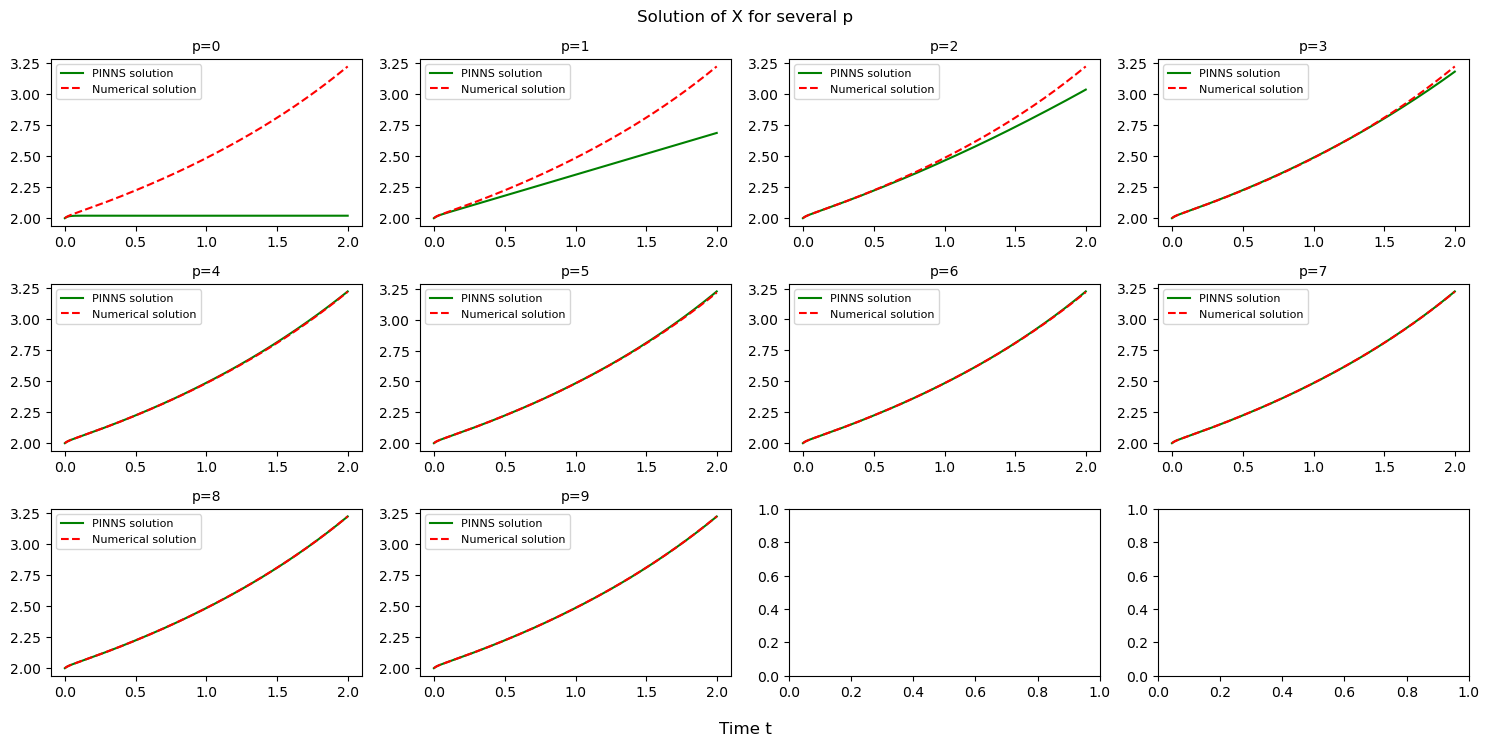

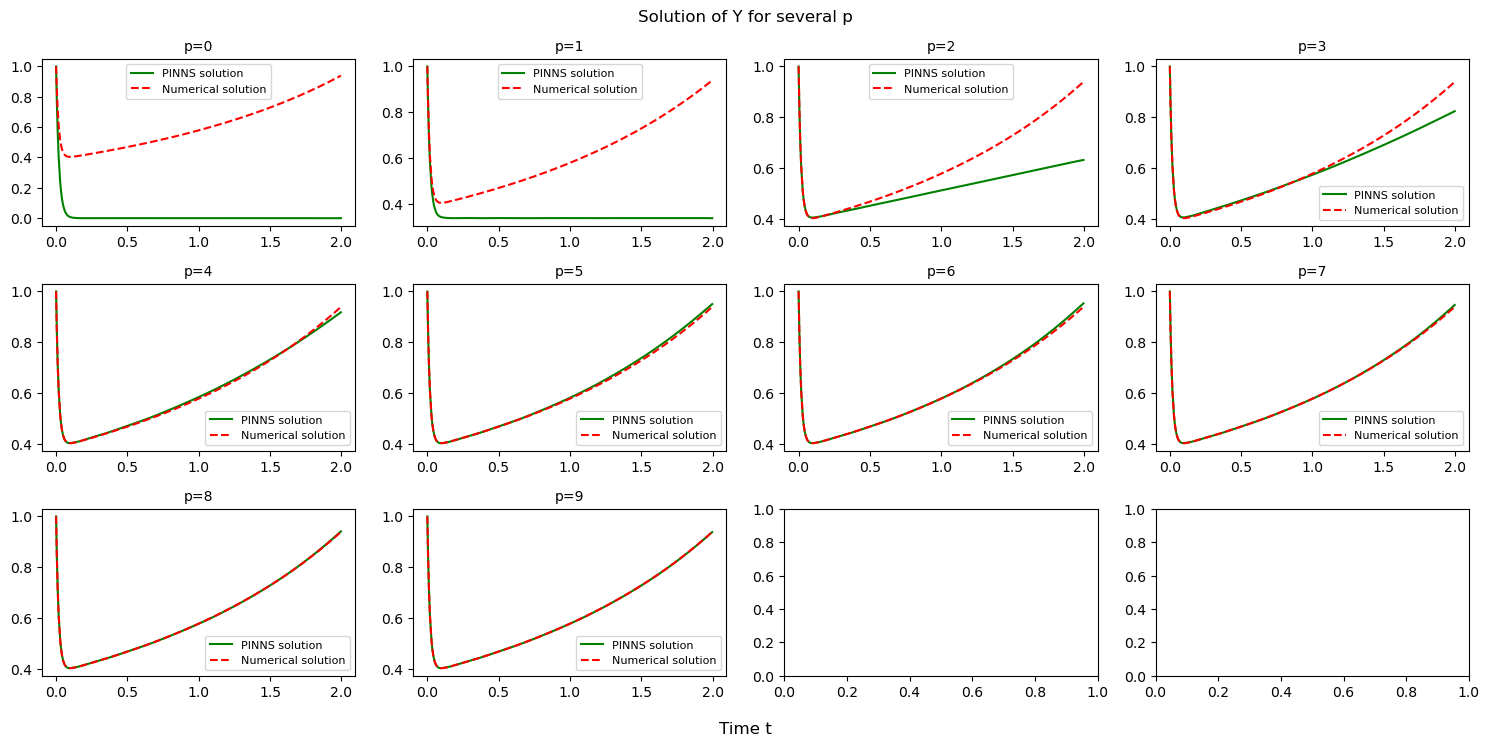

In [33]:
# Numerical - Numerical Perturbation X
nb_row_plot = (len(p_list)+1)//4+1 if (len(p_list))%4!=0 else (len(p_list)+1)//4
fig, ax = plt.subplots(nb_row_plot, 4, figsize=(15, nb_row_plot*2.5))
for i in range(len(p_list)):
  j = i//4; k = i%4
  ax[j][k].plot(t_numpy, sol_PINNS_list[i][:, 0], 'g', label='PINNS solution')
  if compute_numerical_pert:
    ax[j][k].plot(t_numpy, sol_num_list[i][:, 0], '--', label='Numerical solution by perturbation')
  ax[j][k].plot(t_numpy, non_linear_num_sol.y[0], '--r', label='Numerical solution')
  ax[j][k].legend(fontsize=8)
  ax[j][k].set_title(f"p={p_list[i]}", fontsize=10)
fig.supxlabel("Time t");
fig.suptitle("Solution of X for several p");
fig.tight_layout()

# Numerical - Numerical Perturbation Y
nb_row_plot = (len(p_list)+1)//4+1 if (len(p_list))%4!=0 else (len(p_list)+1)//4
fig, ax = plt.subplots(nb_row_plot, 4, figsize=(15, nb_row_plot*2.5))
for i in range(len(p_list)):
  j = i//4; k = i%4
  ax[j][k].plot(t_numpy, sol_PINNS_list[i][:, 1], 'g', label='PINNS solution')
  if compute_numerical_pert:
    ax[j][k].plot(t_numpy, sol_num_list[i][:, 1], '--', label='Numerical solution by perturbation')
  ax[j][k].plot(t_numpy, non_linear_num_sol.y[1], '--r', label='Numerical solution')
  ax[j][k].legend(fontsize=8)
  ax[j][k].set_title(f"p={p_list[i]}", fontsize=10)
fig.supxlabel("Time t");
fig.suptitle("Solution of Y for several p");
fig.tight_layout()

# Comparative analysis with numerical methods on several alpha
- Solve iteratively for several alpha value
- Solve with:
    - PINNS transfer
    - RK45
    - Radeau
    - LSODA
- Get:
    - PINSS: Error + Time to compute
    - RK45: Error + Time to compute
    - Radau: Error + Time to compute
    - LSODA: Error + Time to compute

In [16]:
r_tol = 1e-8
numerical_sol_fct_radau = lambda x, IC, alpha, beta=beta, r_tol=r_tol, domain=domain: numerical_non_linear_solution(alpha, beta, IC, domain, x,
                                                                                                                    method="Radau", r_tol=r_tol).y

numerical_sol_fct_rk45 = lambda x, IC, alpha, beta=beta, r_tol=r_tol, domain=domain: numerical_non_linear_solution(alpha, beta, IC, domain, x,
                                                                                                                   method="RK45", r_tol=r_tol).y

numerical_sol_fct_lsoda = lambda x, IC, alpha, beta=beta, r_tol=r_tol, domain=domain: numerical_non_linear_solution(alpha, beta, IC, domain, x,
                                                                                                                   method="LSODA", r_tol=r_tol).y

numerical_methods = {"RK45": numerical_sol_fct_rk45, "Radau": numerical_sol_fct_radau}

In [19]:
import time
from collections import defaultdict
from tqdm import tqdm


alpha_list_transfer = [20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 100, 150, 200]
# alpha_list_transfer = [i for i in range(2, 41, 2)]
log_scale = True
p = 1


computational_time = defaultdict(list)
max_error = defaultdict(list)
mean_error = defaultdict(list)

solution = defaultdict(list)

length = t_eval.shape[0]

for alpha in tqdm(alpha_list_transfer):

    A_transfer = get_A(alpha)

    # solve with PINNS
    pinns_sol, _, _, _, total_time = solve_perturbation_TL(beta=beta, p=p, t_eval=t_eval,
                                                           alpha=alpha, A=A_transfer,
                                                           force=force_transfer, IC=IC_transfer,
                                                           H=H, H_0=H_0, dH_dt=dH_dt_new, dev=dev,
                                                           force_func_index=force_func_index,
                                                           numerical_sol_fct=numerical_sol_fct,
                                                           force_function_PINNS=force_function_PINNS,
                                                           force_function_numerical=force_function_numerical,
                                                           compute_numerical_pert=False,
                                                           numerical_perturbation_fct=numerical_perturbation_fct,
                                                           verbose=False)
    solution["PINNS"].append(pinns_sol.T)
    computational_time["PINNS"].append(total_time)

    # solve with numerical methods
    for method, fct in numerical_methods.items():
        start = time.time()
        numerical_sol = fct(t_eval.detach().cpu().numpy().squeeze(),
                            IC_transfer.detach().cpu().numpy().squeeze(),
                            alpha)
        solution[method].append(numerical_sol)
        end = time.time()
        computational_time[method].append(end-start)

    # # true solution
    # true_solution = true_solution_Dho(alpha, v[0].item(), v[1].item(), t_eval.detach().cpu().numpy())
    # solution["True"].append(true_solution)

    # # get error
    # max_error["PINNS"].append([]); 
    # mean_error["PINNS"].append([]); 
    # for method in numerical_methods.keys():
    #     max_error[method].append([])
    #     mean_error[method].append([])
    # for i in range(num_equations):
    #   # pinns error
    #   predicted_vals = pinns_sol[:, i, :].detach().cpu().numpy().squeeze()
    #   pinns_erros = np.abs(predicted_vals - true_solution[i, :])
    #   max_error["PINNS"][-1].append(pinns_erros.max())
    #   mean_error["PINNS"][-1].append(pinns_erros.mean())
    #   # Numerical error
    #   for method in numerical_methods.keys():
    #     sol = solution[method]
    #     numerical_error = np.abs(sol[-1][i] - true_solution[i])
    #     max_error[method][-1].append(numerical_error.max())
    #     mean_error[method][-1].append(numerical_error.mean())

100%|██████████| 13/13 [00:06<00:00,  2.16it/s]


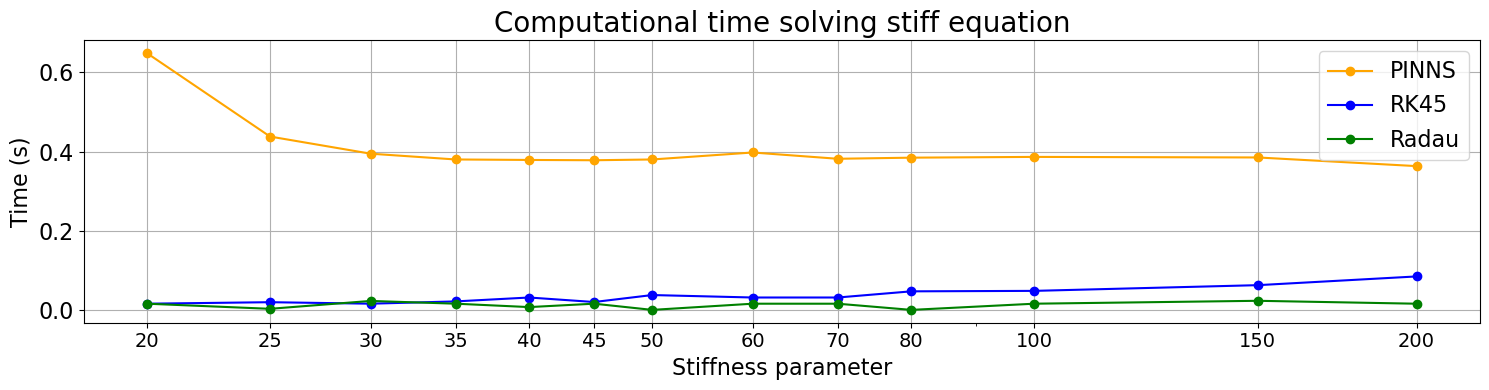

In [20]:
color = {"PINNS": 'orange', "RK45": 'b', "Radau": 'g', 'LSODA': 'm', "True": (1, 0, 0, 0.5)}
fig, ax = plt.subplots(1, tight_layout=True, figsize=(15, 4))

for method, time in computational_time.items():
    ax.plot(alpha_list_transfer, time, "-o", color=color[method], label=f"{method}")

#ax.set_yscale("log")
if log_scale: ax.set_xscale("log")
ax.set_title("Computational time solving stiff equation", fontsize=20)
ax.set_xlabel('Stiffness parameter', fontsize=16)
ax.set_ylabel('Time (s)', fontsize=16)
ax.set_xticks(alpha_list_transfer, [str(i) for i in alpha_list_transfer])
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=16)
ax.legend(loc='best', fontsize=16)
ax.grid()

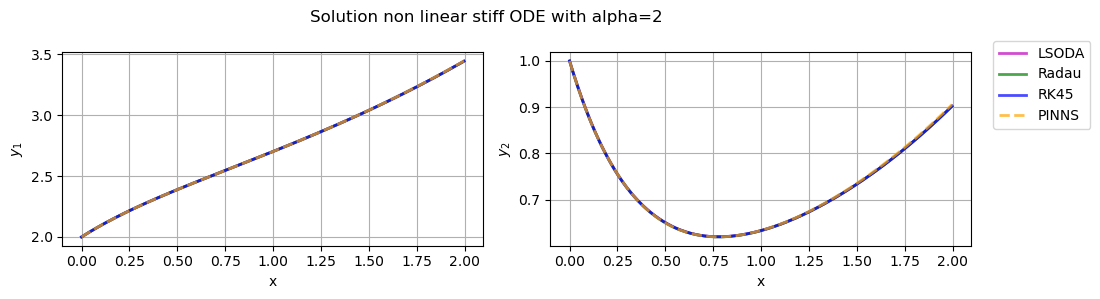

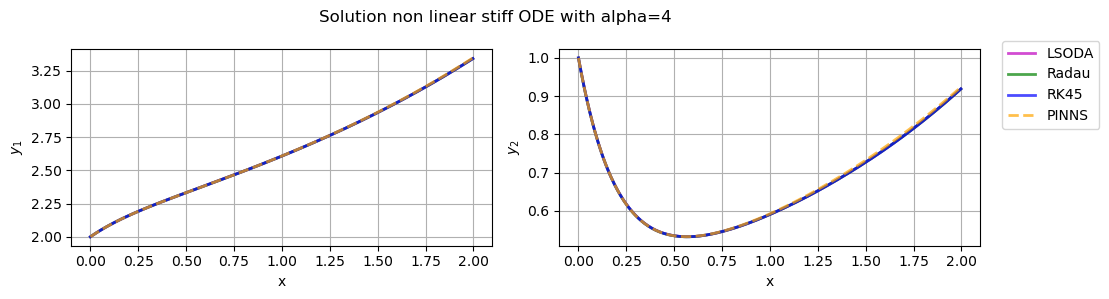

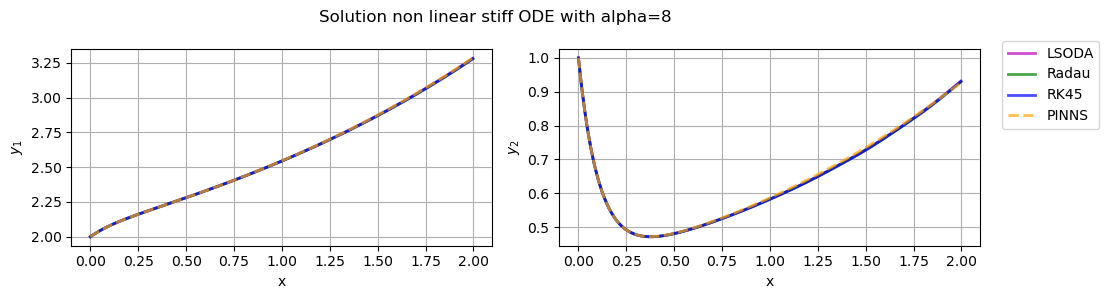

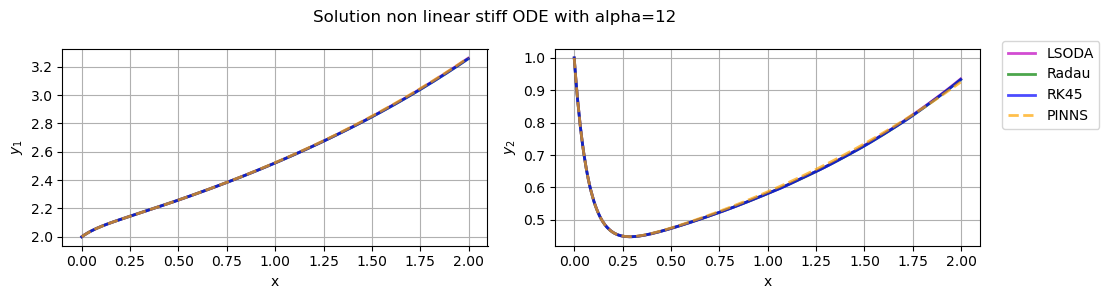

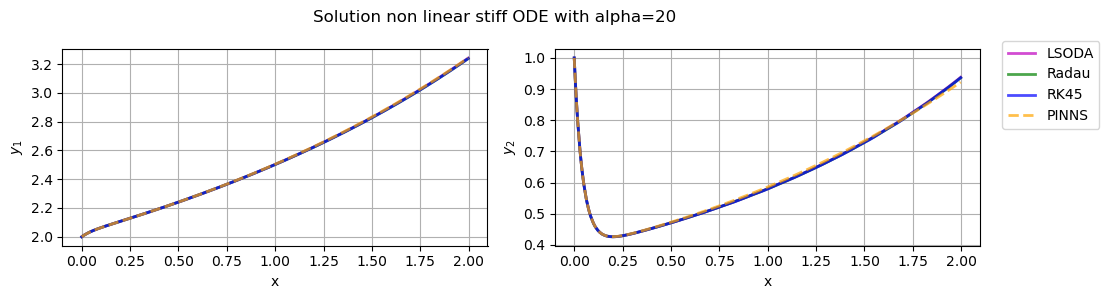

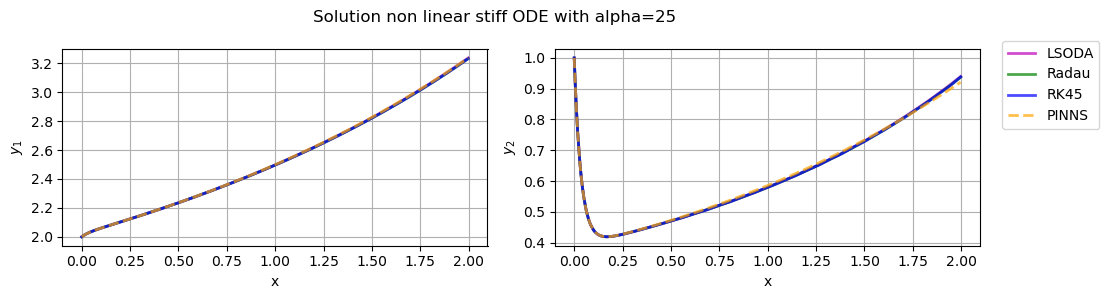

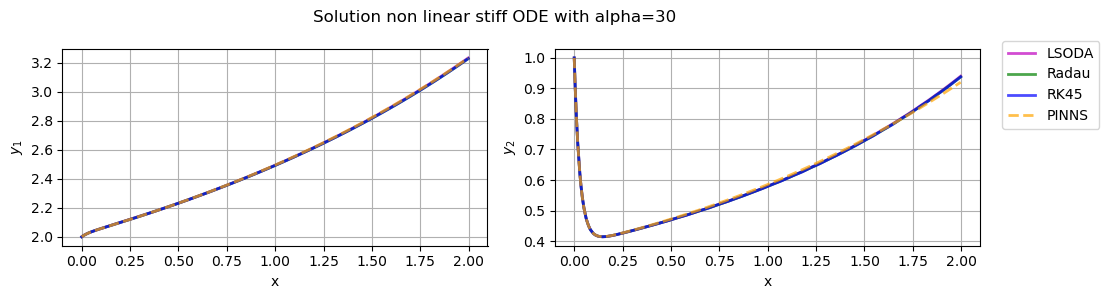

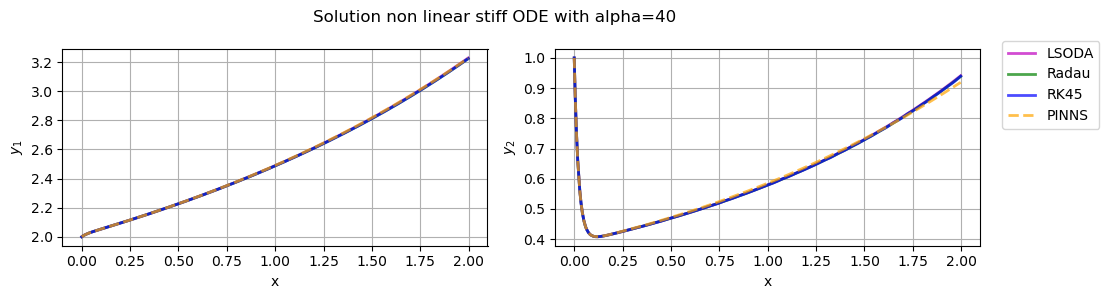

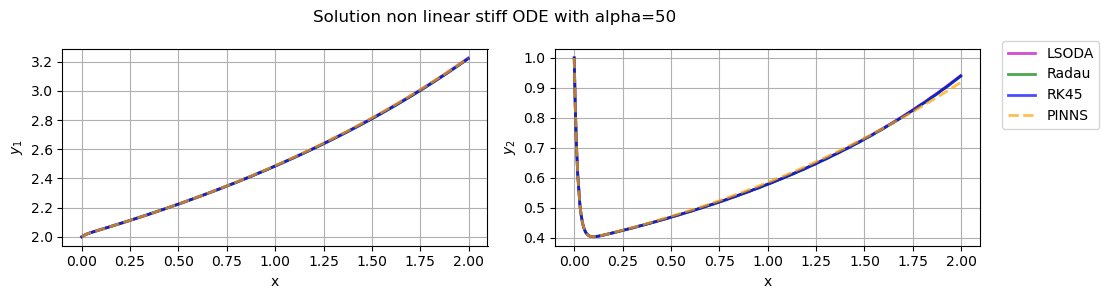

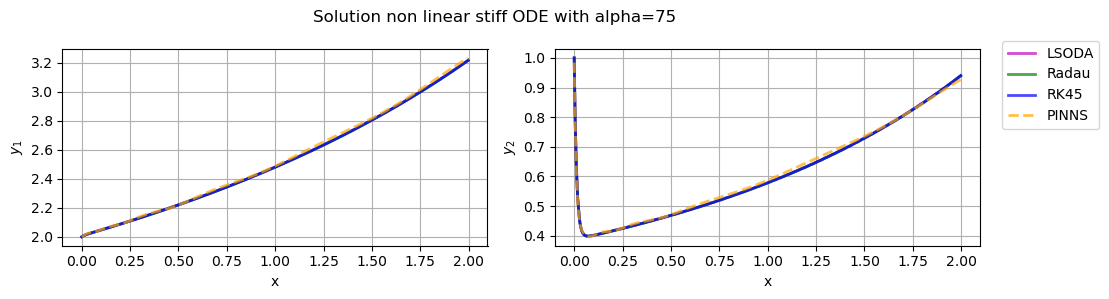

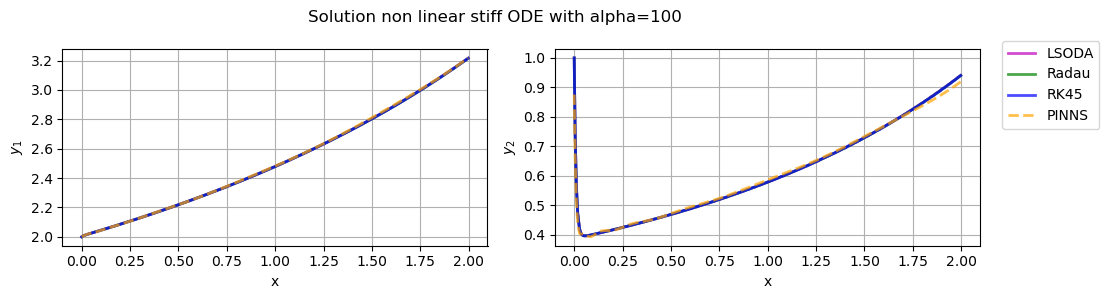

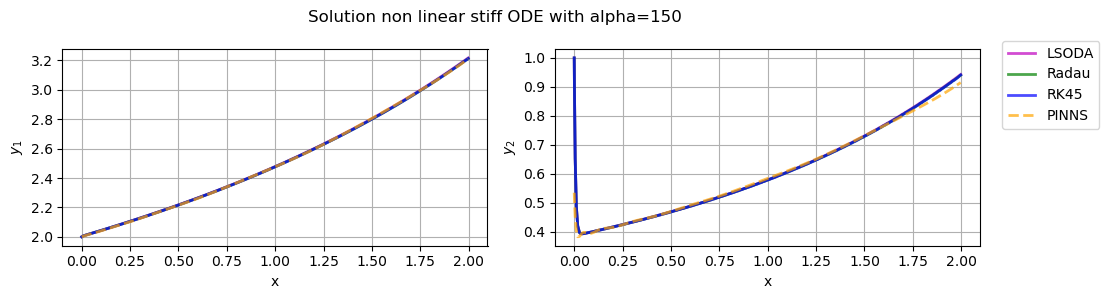

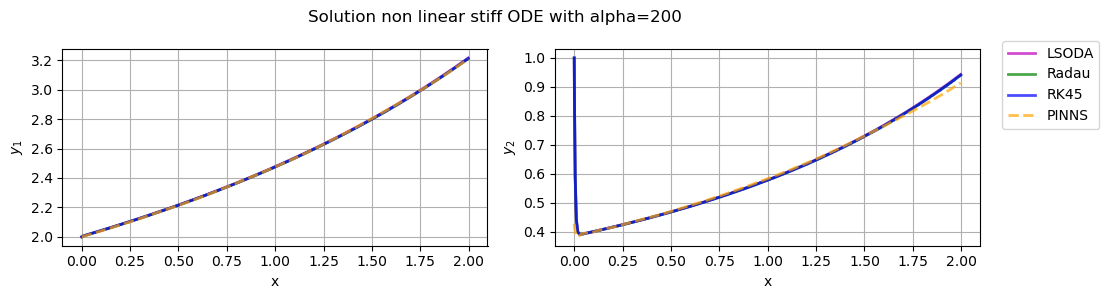

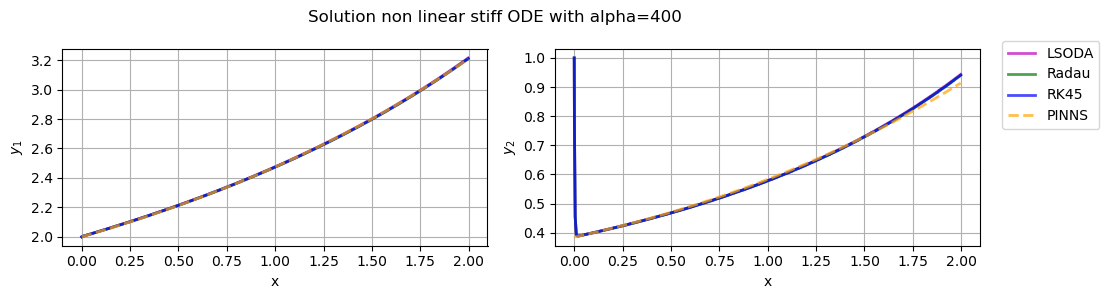

In [37]:
for i in range(len(alpha_list_transfer)):
    fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10, 3), sharex=True)
    for method, value in reversed(solution.items()):
        ax[0].plot(t_eval.detach().cpu().squeeze(), value[i][0, :].squeeze(), "--"if method=="PINNS" else "-",
                   color=color[method], label=f"{method}", alpha=0.7, linewidth=2)
        ax[1].plot(t_eval.detach().cpu().squeeze(), value[i][1, :].squeeze(), "--"if method=="PINNS" else "-",
                   color=color[method], alpha=0.7, linewidth=2)

    ax[0].set_xlabel('x')
    ax[0].set_ylabel('$y_1$')
    ax[0].tick_params(axis='x')
    ax[0].tick_params(axis='y')

    ax[0].grid()

    ax[1].set_xlabel('x')
    ax[1].set_ylabel('$y_2$')
    ax[1].tick_params(axis='x')
    ax[1].tick_params(axis='y')
    ax[1].grid()

    fig.suptitle(f"Solution non linear stiff ODE with alpha={alpha_list_transfer[i]}")
    fig.legend(loc='upper left', bbox_to_anchor=(1, 0.9))